In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
import statsmodels.api as sm

# %matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

# 데이터분석 스케치

## [Horse colic](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+)

+ team 
  + 권순호, 윤지원, 김원정
  

+ index
	* EDA(Exploratory data analysis)
	* Feature selection
	* Modeling
	* Model selection

## EDA
+ 변수 탐색 및 분류
  + 변수 이름과 설명
  + 상관관계가 없는 변수는 어떤것이 있나?
  + 의미없는값, 전처리가 필요한 값들을 선별및 가공하자

In [3]:
df = pd.read_csv('./horse.csv')
df['outcome'] = df.pop('outcome')

In [4]:
df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,no,11300,0,0,no,died
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,no,2208,0,0,no,euthanized
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,no,0,0,0,yes,lived
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,yes,2208,0,0,yes,died
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,no,4300,0,0,no,died


In [5]:
null_count = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
null_count['percentage'] = null_count/len(df)

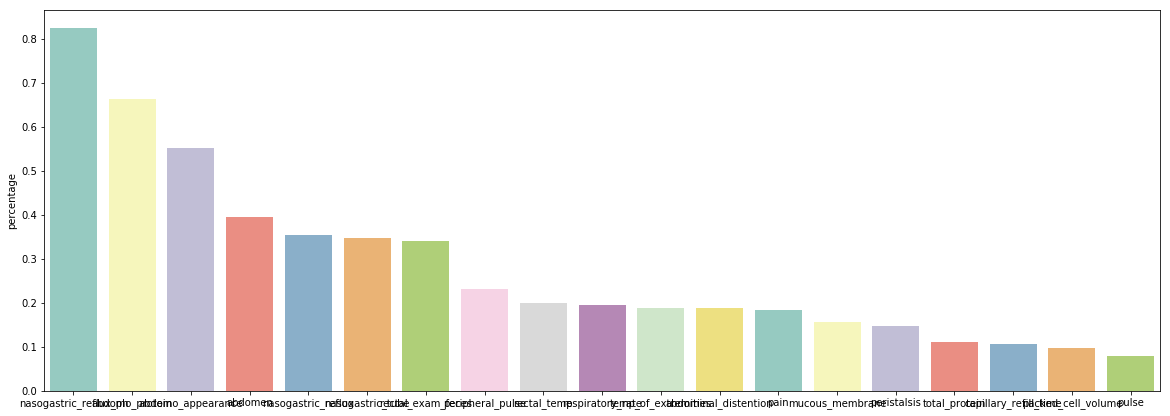

In [6]:
plt.figure(figsize=(20, 7))
sns.barplot(x=null_count.head(19).index, y='percentage', data=null_count.head(19), palette="Set3")
plt.show()

In [7]:
cate = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 
       'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']
numeric = ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 
           'total_protein', 'abdomo_protein']

In [8]:
cate2 = ['temp_of_extremities', 'mucous_membrane', 'pain', 
         'peristalsis', 'abdominal_distention',
         'rectal_exam_feces', 'abdomo_appearance', 
         'surgical_lesion']

In [9]:
cate3 = ['age', 'pain', 'peristalsis', 'nasogastric_tube',
         'abdomen', 'surgical_lesion']

In [10]:
df['abdomo_appearance'].value_counts()

cloudy           47
serosanguious    46
clear            41
Name: abdomo_appearance, dtype: int64

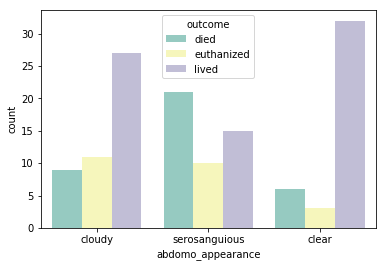

In [11]:
sns.countplot('abdomo_appearance', hue='outcome', data=df, palette="Set3")
plt.show()

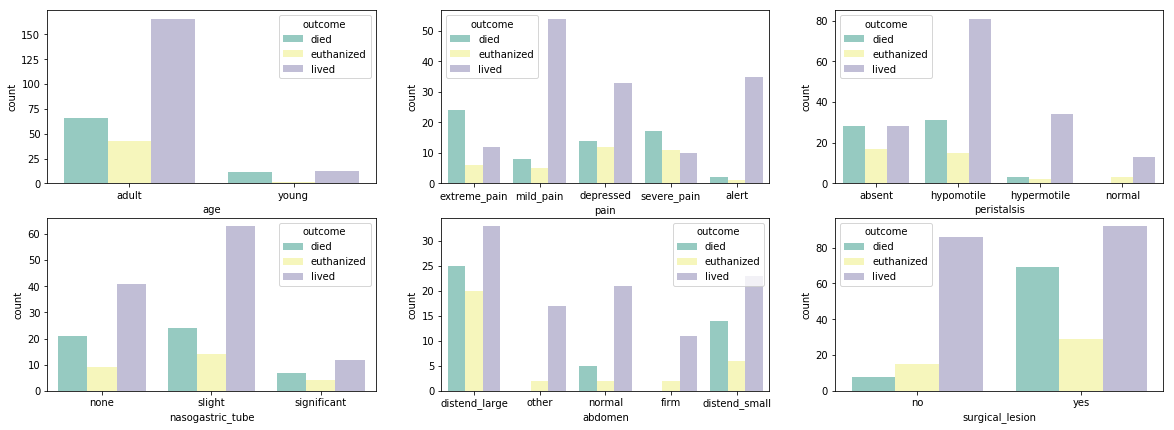

In [12]:
plt.figure(figsize=(20, 7))
for i, feature in enumerate(cate3):
    plt.subplot(2,3,i+1)
    sns.countplot(feature, hue='outcome', data=df, palette="Set3")
plt.show()

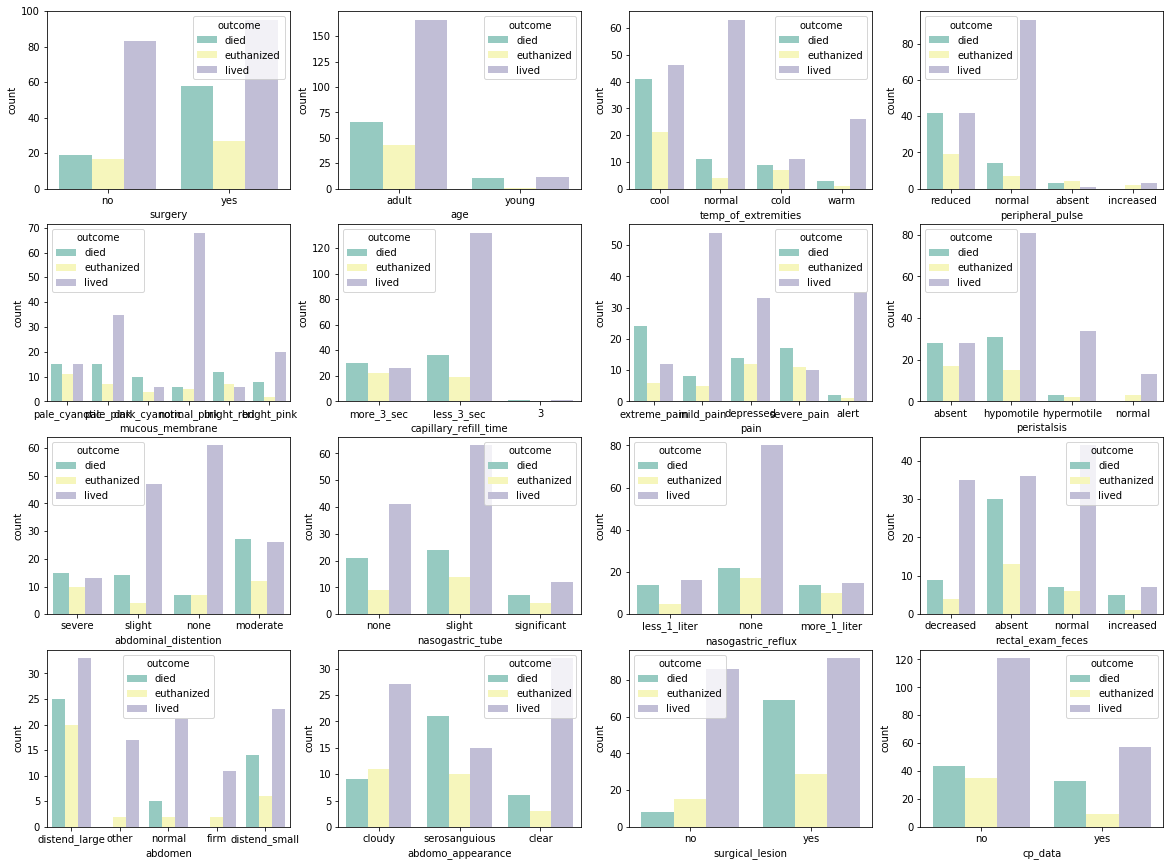

In [13]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(cate):
    plt.subplot(4,4,i+1)
    sns.countplot(feature, hue='outcome', data=df, palette="Set3")
plt.show()

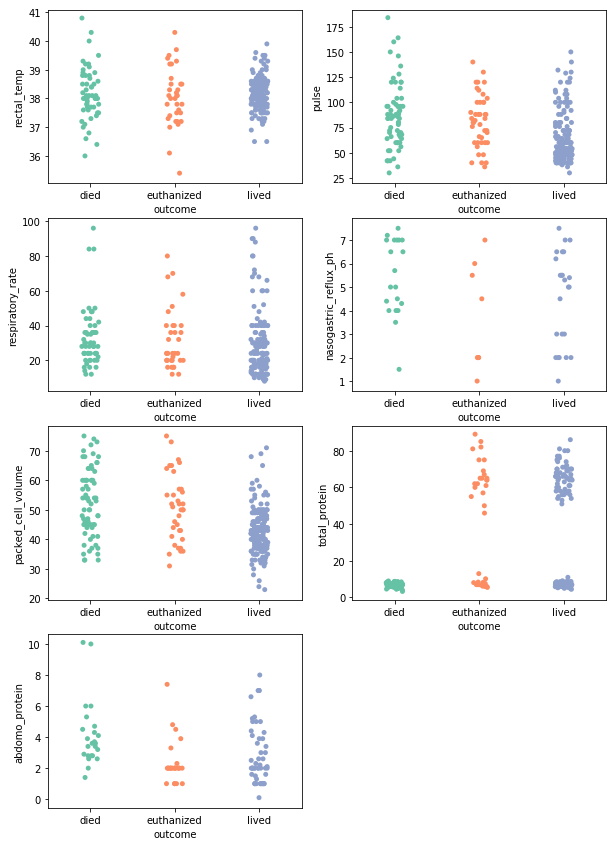

In [14]:
plt.figure(figsize=(10, 30))
for i, feature in enumerate(numeric):
    plt.subplot(8,2,i+1)
    sns.stripplot("outcome", feature, data=df, jitter=True, palette="Set2")
plt.show()

### 변수 이름과 설명 :

In [15]:
def cat_plot(feature, df=df, outcome='outcome', size=(10,3), palette='Set3'):
    plt.figure(figsize=size)
    plt.subplot(1,3,1)
    sns.countplot(x=feature, data=df, palette="Set3")
    plt.subplot(1,3,2)
    sns.countplot(outcome, hue=feature, data=df, palette="Set3")
    plt.subplot(1,3,3)
    sns.countplot(feature, hue=outcome, data=df, palette="Set3")
    plt.show()
    return None

In [16]:
def missing_per(feature):
    percentage = df[feature].isnull().sum() / len(df[feature]) * 100
    return percentage

surgery?(수술 경험)
  - 1 = Yes, it had surgery
  - 2 = No, It was treated without surgery

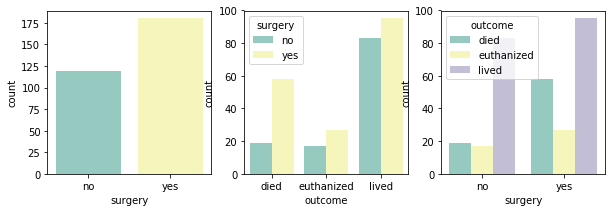

In [17]:
cat_plot("surgery")

Age(나이)
- 1 = 성인 말
- 2 = 어린 말 (< 6개월)

In [18]:
df['age'].value_counts()

adult    275
young     24
Name: age, dtype: int64

In [19]:
275/299

0.919732441471572

In [20]:
24/299

0.0802675585284281

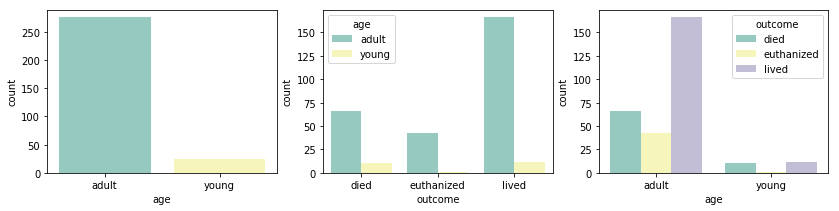

In [21]:
cat_plot("age", size=(14, 3))

Hospital Number(병원 번호)
 - 숫자 ID
 - 말에 지정된 case number
      (만약 말을 1회 이상 치료한다면 특별하지 않을 수 있다.)

rectal temperature(직장 온도)
 - linear
 - in degrees celsius.
 - 감염으로 인해 고온이 발생할 수 있습니다.
 - 동물이 late shock을 받으면 온도가 낮아질 수 있다.
 - 정상 온도는 37.8
 - 이 매개 변수는 일반적으로 문제가 진행됨에 따라 변경됩니다. (예를 들어, 말이 충격에 빠질 때 정상 범위를 통과하면서 병변 때문에 상승할 수 있습니다.)
       

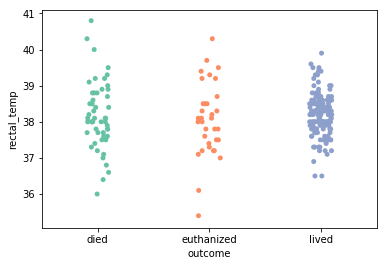

In [22]:
sns.stripplot("outcome", "rectal_temp", data=df, jitter=True, palette='Set2')
plt.show()

pulse(맥박)
 - linear
 - 분당 심장 박동 수
 - is a reflection of the heart condition: 30-40은 성인에게 정상입니다.
 - 경주용 말이지만 일반 말보다 심장박동수가 낮다(분당 20-25정도)
 - 통증이있는 병변이 있거나 순환계 충격을 겪은 동물은 심박수가 상승 할 수 있습니다

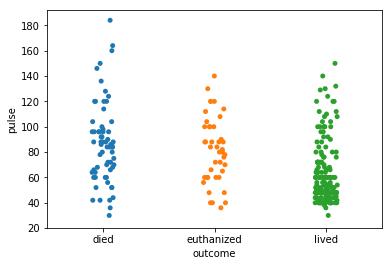

In [23]:
sns.stripplot("outcome", "pulse", data=df, jitter=True)
plt.show()

respiratory rate(호흡 속도)
 - linear
 - normal rate is 8 to 10
 - 심한 변동 때문에 유용성이 의심스럽습니다.

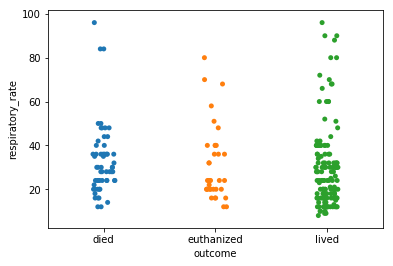

In [24]:
sns.stripplot("outcome", "respiratory_rate", data=df, jitter=True)
plt.show()

temperature of extremities(팔 다리의 온도)
 - 말초 혈액 순환의 주관적 표시
 - possible values:
   - 1 = Normal
   - 2 = Warm
   - 3 = Cool
   - 4 = Cold
 - cool와 cold는 쇼크의 가능성을 보여줍니다.
 - 고열 사지는 직장 온도 상승과 관련이 있습니다.

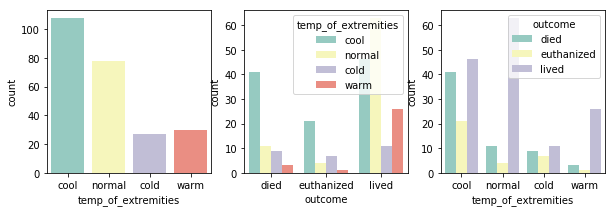

In [25]:
cat_plot("temp_of_extremities")

peripheral pulse(말초 맥박)
 - subjective
 - possible values are:
   - 1 = normal
   - 2 = increased
   - 3 = reduced
   - 4 = absent
 - normal or increased p.p.는 적절한 순환을 나타내며 reduced or absent는 나쁜 perfusion을 나타냅니다.

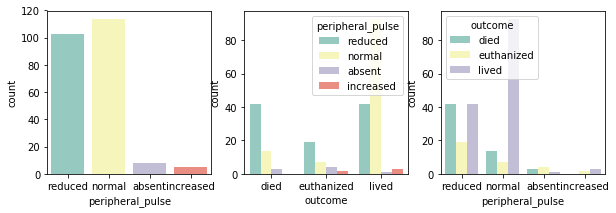

In [26]:
cat_plot("peripheral_pulse")

mucous membranes(점막)
 - 주관적인 색의 측정
 - possible values are:
   - 1 = normal pink
   - 2 = bright pink
   - 3 = pale pink
   - 4 = pale cyanotic
   - 5 = bright red / injected
   - 6 = dark cyanotic
 - 1, 2는 정상 또는 약간 증가 된 혈액 순환을 나타냅니다
 - 3 는 early shock 발생일수도 있습니다.
 - 4,6 은 심각한 순환 기관의 손상을 나타낸다.
 - 5는 패혈증을 더 많이 나타낸다.

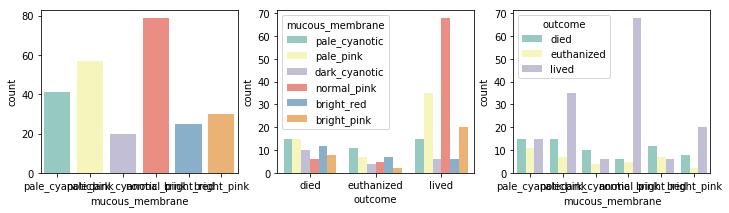

In [27]:
cat_plot("mucous_membrane", size=(12, 3))

capillary refill time(모세관 주입 시간)
  - 임상 적 판단. 리필 시간이 길수록 혈액 순환이 원활하지 않음.
  - possible values
    - 1 = < 3 seconds
    - 2 = >= 3 seconds

In [28]:
df['capillary_refill_time'].replace({'3': 'more_3_sec'}, inplace=True)

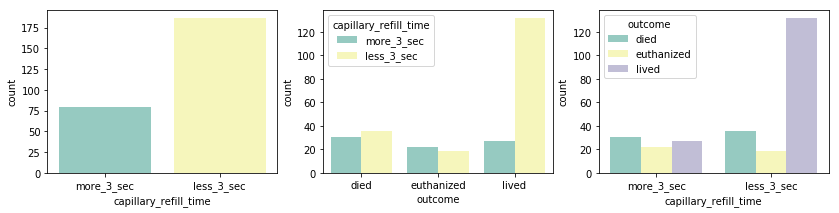

In [29]:
cat_plot("capillary_refill_time", size=(14, 3))

pain 
  - 말의 통증 수준에 대한 주관적인 판단
  - possible values:
    - 1 = alert, no pain
    - 2 = depressed
    - 3 = intermittent mild pain
    - 4 = intermittent severe pain
    - 5 = continuous severe pain
  - should NOT be treated as a ordered or discrete variable!
  - 일반적으로 통증이 심할수록 수술이 필요할 가능성이 높습니다.
  - 통증을 미리 치료하면 통증 수준을 어느 정도 가릴 수 있습니다.

In [30]:
missing_per('pain')

18.394648829431436

In [31]:
df['pain'].value_counts()

mild_pain       67
depressed       59
extreme_pain    42
severe_pain     38
alert           38
Name: pain, dtype: int64

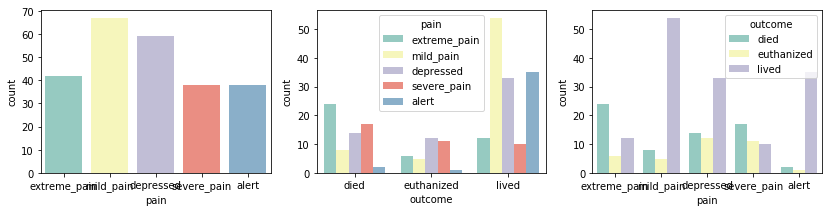

In [32]:
cat_plot("pain", size=(14,3))

peristalsis(연동운동)                        
  - 말의 장내 활동의 표시. 내장이 점점 팽창하거나 말이 더 독성이 생기면서 활동은 감소한다.
  - possible values:
    - 1 = hypermotile
    - 2 = normal
    - 3 = hypomotile
    - 4 = absent

In [33]:
missing_per('peristalsis')

14.715719063545151

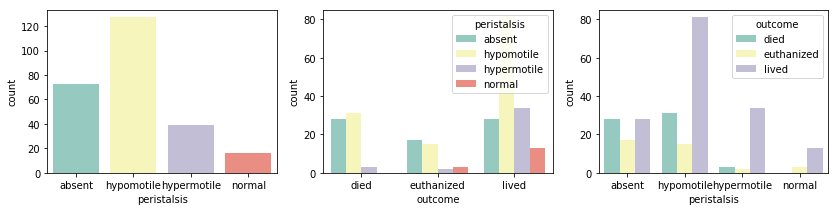

In [34]:
cat_plot("peristalsis", size=(14, 3))

abdominal distension(복부 팽창)
  -  An IMPORTANT parameter.
  - possible values
    - 1 = none
    - 2 = slight
    - 3 = moderate
    - 4 = severe
  - 복부 팽만감을 가진 동물은 고통스럽고 내장 운동성을 감소시킬 수 있습니다.
  - 복부 팽창이 심한 말은 단지 압력을 완화시키기 위해 수술이 필요할 것이다.

In [35]:
missing_per('abdominal_distention')

18.729096989966553

In [36]:
df['abdominal_distention'].value_counts()

none        75
moderate    65
slight      65
severe      38
Name: abdominal_distention, dtype: int64

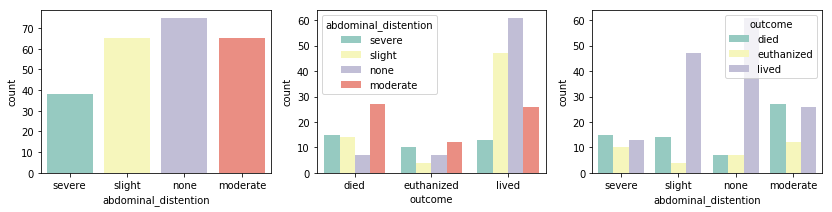

In [37]:
cat_plot("abdominal_distention", size=(14,3))

nasogastric tube(비위 관)
  - 이것은 튜브에서 나오는 가스를 의미합니다.
  - possible values:
    - 1 = none
    - 2 = slight
    - 3 = significant
  - 위에 있는 큰 가스 캡은 말을 불편하게 할 수 있다.

In [38]:
missing_per('nasogastric_tube')

34.782608695652172

In [39]:
df['nasogastric_tube'].value_counts()

slight         101
none            71
significant     23
Name: nasogastric_tube, dtype: int64

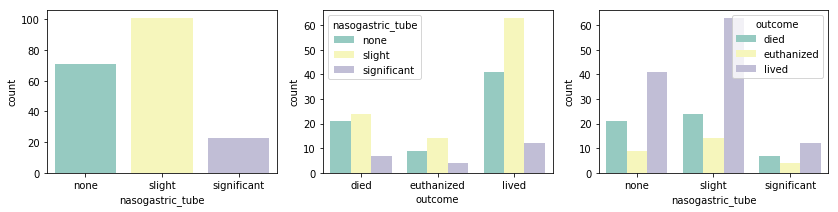

In [40]:
cat_plot("nasogastric_tube", size = (14, 3))

nasogastric reflux(비위 역류)
  - possible values
    - 1 = none
    - 2 = > 1 liter
    - 3 = < 1 liter
  - 역류 량이 많을수록 장의 나머지 부분으로부터의 유체 통로에 심각한 장애물이있을 확률이 높습니다

In [41]:
missing_per('nasogastric_reflux')

35.451505016722408

In [42]:
df['nasogastric_reflux'].value_counts()

none            119
more_1_liter     39
less_1_liter     35
Name: nasogastric_reflux, dtype: int64

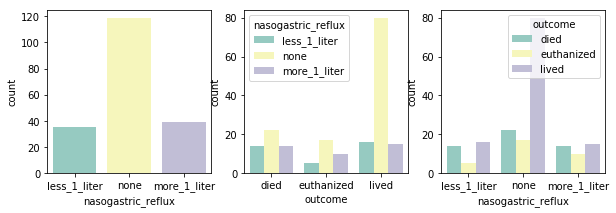

In [43]:
cat_plot("nasogastric_reflux")

nasogastric reflux PH(비위 관성 환류 PH)
  - linear
  - scale is from 0 to 14 with 7 being neutral
  - 정상 값은 3에서 4 범위에 있습니다.

drop시키는게 좋을듯

In [44]:
missing_per('nasogastric_reflux_ph')

82.274247491638803

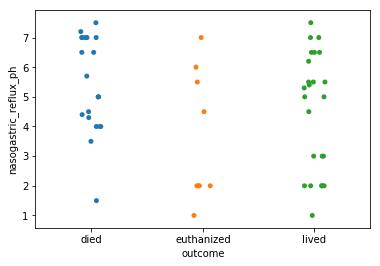

In [45]:
sns.stripplot("outcome", "nasogastric_reflux_ph", data=df, jitter=True)
plt.show()

rectal examination - feces(직장 검사 - 대변)
  - possible values
    - 1 = normal
    - 2 = increased
    - 3 = decreased
    - 4 = absent
  - 배설물이 없다는 것은 아마도 장애를 나타냅니다.

In [46]:
missing_per('rectal_exam_feces')

34.113712374581937

In [47]:
df['rectal_exam_feces'].value_counts()

absent       79
normal       57
decreased    48
increased    13
Name: rectal_exam_feces, dtype: int64

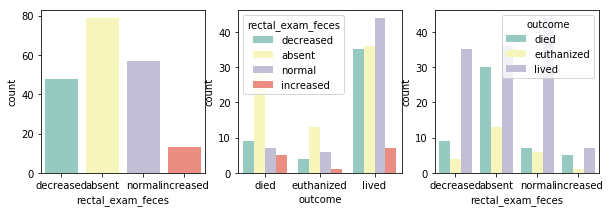

In [48]:
cat_plot("rectal_exam_feces")

abdomen(복부)
  - possible values
    - 1 = normal
    - 2 = other
    - 3 = firm feces in the large intestine
    - 4 = distended small intestine
    - 5 = distended large intestine
  - 3은 아마도 기계적인 충격에 의해 야기된 방해물일 것이다, 그리고 보통 의학적으로 치료된다.
  - 4 및 5는 수술 병변을 나타낸다

In [49]:
df['abdomen'].value_counts()

distend_large    78
distend_small    43
normal           28
other            19
firm             13
Name: abdomen, dtype: int64

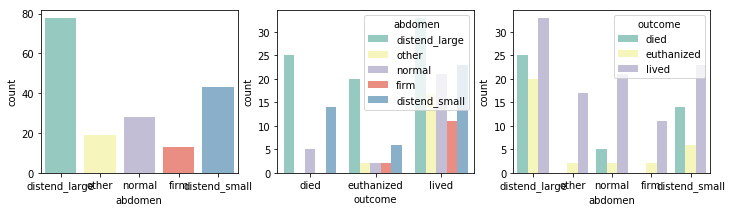

In [50]:
cat_plot("abdomen", size=(12, 3))

packed cell volume
- linear
- 혈액 속의 적혈구의 수
- 정상 범위는 30 ~ 50입니다. 혈액 순환이 원활 해지거나 동물이 탈수됨에 따라 혈중 농도가 상승합니다.

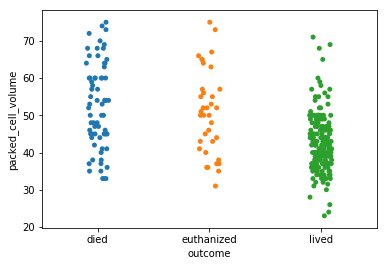

In [51]:
sns.stripplot("outcome", "packed_cell_volume", data=df, jitter=True)
plt.show()

total protein(총 단백질)
  - linear
  - 정상적인 값은 6-7.5 (gms / dL) 범위입니다
  - 값이 높을수록 탈수량이 커집니다.

In [52]:
missing_per('total_protein')

11.036789297658862

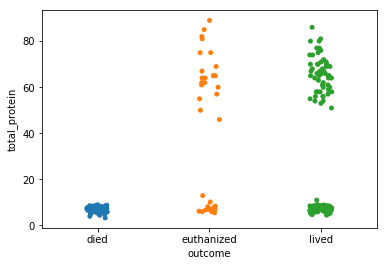

In [53]:
sns.stripplot("outcome", "total_protein", data=df, jitter=True)
plt.show()

abdominocentesis appearance(복강경 외관)
  - 말의 복부에 바늘을 넣고 복강으로부터 유체를 얻는다.
  - possible values:
    - 1 = clear
    - 2 = cloudy
    - 3 = serosanguinous
  - normal fluid is clear while cloudy or serosanguinous indicates a compromised gut

In [54]:
missing_per('abdomo_appearance')

55.18394648829431

In [55]:
df['abdomo_appearance'].value_counts()

cloudy           47
serosanguious    46
clear            41
Name: abdomo_appearance, dtype: int64

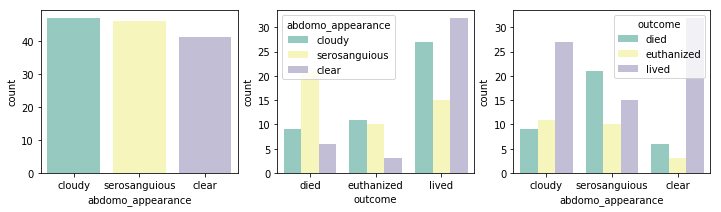

In [56]:
cat_plot("abdomo_appearance", size=(12, 3))

abdomcentesis total protein(복강 내 총 단백질)
  - linear
  - 단백질 수준이 높을수록 손상된 창자가 더 많을 것입니다. 값은 gms / dL 단위입니다.

drop 시키는거 고려

In [57]:
missing_per('abdomo_protein')

66.220735785953181

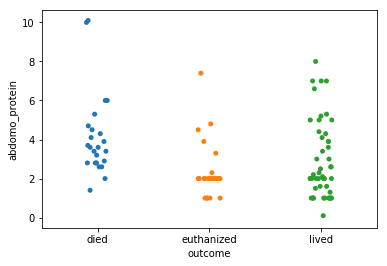

In [58]:
sns.stripplot("outcome", "abdomo_protein", data=df, jitter=True)
plt.show()

surgical lesion? (외과 적 병변)
  - retrospectively, was the problem (lesion) surgical?
  -  colic의 원인을 찾으려면 일단 배를 갈라봐야 알수 있기 때문에 수술하는과정에서 알아내거나(Yes) 부검해서 알아낸다(no).
  - possible values:
    - 1 = Yes
    - 2 = No

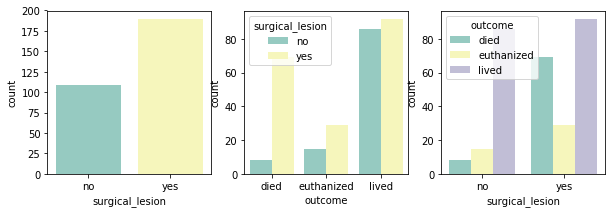

In [59]:
cat_plot("surgical_lesion")

25, 26, 27: type of lesion
- 첫 번째 숫자는 병변의 위치입니다.
  - 1 = gastric (위(胃)의)
  - 2 = sm intestine (sm 창자)
  - 3 = lg colon (결장)
  - 4 = lg colon and cecum (결장과 맹장)
  - 5 = cecum (맹장)
  - 6 = transverse colon (횡행결장)
  - 7 = retum/descending colon (/하행 결장)
  - 8 = uterus (자궁)
  - 9 = bladder (방광)
  - 11 = all intestinal sites (모든 창자 부위)
  - 00 = none (없음)
  
  
- 두 번째 숫자는 유형입니다.
  - 1 = simple (단순한)
  - 2 = strangulation (교살)
  - 3 = inflammation (염증)
  - 4 = other
  
  
- 세 번째 숫자는 하위 유형입니다.
  - 1 = mechanical
  - 2 = paralytic
  - 0 = n/a
  
  
- 네 번째 숫자는 특정 코드입니다.
  -  1 = obturation
  -  2 = intrinsic
  -  3 = extrinsic
  -  4 = adynamic
  -  5 = volvulus/torsion
  -  6 = intussuption
  -  7 = thromboembolic
  -  8 = hernia
  -  9 = lipoma/slenic incarceration
  -  10 = displacement
  -  0 = n/a

In [60]:
df['lesion_1'].unique()

array([11300,  2208,     0,  4300,  3124,  3205,  2124,  2111,  4124,
        2112,  3207,  1400,  4205,  3111,  4122,  2207,  2209,  1124,
        7111,  5205,  2113,  9400,  2305,  7209,  7400,  3112,  3209,
        2322, 11124,  3025,  2205,  5206,   400,  5000,  5400, 31110,
        2206,  5124,  7113,  6209,  3400,  6112,  6111,  1111,  2300,
       21110,  4111,  3133,  5111,   300,  3115,  9000,  3300,  3113,
       41110, 11400, 12208,  4206,  4207,  8300,  8400], dtype=int64)

In [61]:
df['lesion_2'].unique()

array([   0, 1400, 7111, 3111, 6112, 3112], dtype=int64)

In [62]:
df['lesion_3'].unique()

array([   0, 2209], dtype=int64)

cp_data
  - is pathology data present for this case?
    - 1 = Yes
    - 2 = No
  - 이러한 변수는 병리학 데이터가 포함되지 않거나 수집되지 않기 때문에 중요하지 않다.

In [63]:
df['cp_data'].value_counts()

no     200
yes     99
Name: cp_data, dtype: int64

In [64]:
200/299

0.6688963210702341

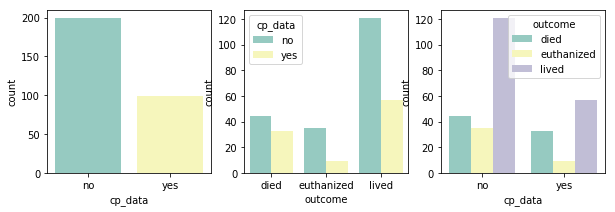

In [65]:
cat_plot("cp_data")

outcome(결과)
  - what eventually happened to the horse?
  - possible values:
    - 1 = lived
    - 2 = died
    - 3 = was euthanized

In [66]:
df['outcome'].value_counts()

lived         178
died           77
euthanized     44
Name: outcome, dtype: int64

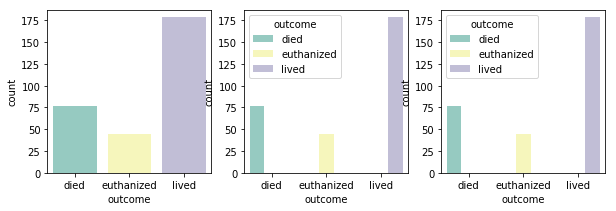

In [67]:
cat_plot("outcome")

In [68]:
from scipy.stats import chisquare
from IPython.display import display

In [69]:
cate = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 
       'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']

In [70]:
for cat in cate:
    statistic, p = chisquare(df[cat].apply(str).value_counts())
    chisq = {"statistic" : statistic, "p-value" : p.round(2)}
    print(cat)
    display(pd.DataFrame(index=["Chi Square"], data=chisq)[["statistic","p-value"]])

surgery


,statistic,p-value
Chi Square,12.444816,0.0


age


,statistic,p-value
Chi Square,210.705686,0.0


temp_of_extremities


,statistic,p-value
Chi Square,77.471572,0.0


peripheral_pulse


,statistic,p-value
Chi Square,176.83612,0.0


mucous_membrane


,statistic,p-value
Chi Square,59.311037,0.0


capillary_refill_time


,statistic,p-value
Chi Square,126.347826,0.0


pain


,statistic,p-value
Chi Square,14.986622,0.01


peristalsis


,statistic,p-value
Chi Square,121.919732,0.0


abdominal_distention


,statistic,p-value
Chi Square,12.956522,0.01


nasogastric_tube


,statistic,p-value
Chi Square,56.67893,0.0


nasogastric_reflux


,statistic,p-value
Chi Square,77.494983,0.0


rectal_exam_feces


,statistic,p-value
Chi Square,75.0301,0.0


abdomen


,statistic,p-value
Chi Square,165.9699,0.0


abdomo_appearance


,statistic,p-value
Chi Square,145.561873,0.0


surgical_lesion


,statistic,p-value
Chi Square,21.943144,0.0


cp_data


,statistic,p-value
Chi Square,34.117057,0.0


In [71]:
aaa = ''
for cat in cate:
    aaa = aaa+ "C(" + cat + ") + "
aaa

'C(surgery) + C(age) + C(temp_of_extremities) + C(peripheral_pulse) + C(mucous_membrane) + C(capillary_refill_time) + C(pain) + C(peristalsis) + C(abdominal_distention) + C(nasogastric_tube) + C(nasogastric_reflux) + C(rectal_exam_feces) + C(abdomen) + C(abdomo_appearance) + C(surgical_lesion) + C(cp_data) + '

In [72]:
cate_str = 'outcome ~ C(surgery) + C(age) + C(temp_of_extremities) + C(peripheral_pulse) + C(mucous_membrane) + C(capillary_refill_time) + C(pain) + C(peristalsis) + C(abdominal_distention) + C(nasogastric_tube) + C(nasogastric_reflux) + C(rectal_exam_feces) + C(abdomen) + C(abdomo_appearance) + C(surgical_lesion) + C(cp_data)'

In [73]:
model = sm.OLS.from_formula(cate_str+'-1', data=df)
result = model.fit()
sm.stats.anova_lm(result, typ=2)

ValueError: shapes (43,3) and (43,3) not aligned: 3 (dim 1) != 43 (dim 0)

Missing values: 30% of the values are missing

## Missing value

In [ ]:
df['rectal_temp'].fillna(value=df['rectal_temp'].mode()[0], inplace=True)
df['pulse'].fillna(value=df['pulse'].mean(), inplace=True)
df['respiratory_rate'].fillna(value=df['respiratory_rate'].mean(), inplace=True)
df['temp_of_extremities'].fillna(value=df['temp_of_extremities'].mode()[0], inplace=True)
df['peripheral_pulse'].fillna(value=df['peripheral_pulse'].mode()[0], inplace=True)
df['mucous_membrane'].fillna(value=df['mucous_membrane'].mode()[0], inplace=True)
df['capillary_refill_time'].fillna(value=df['capillary_refill_time'].mode()[0], inplace=True)
df['pain'].fillna(value=df['pain'].mode()[0], inplace=True)
df['peristalsis'].fillna(value=df['peristalsis'].mode()[0], inplace=True)
df['abdominal_distention'].fillna(value=df['abdominal_distention'].mode()[0], inplace=True)
df['nasogastric_tube'].fillna(value=df['nasogastric_tube'].mode()[0], inplace=True)
df['nasogastric_reflux'].fillna(value=df['nasogastric_reflux'].mode()[0], inplace=True)
df['nasogastric_reflux_ph'].fillna(value=df['nasogastric_reflux_ph'].mean(), inplace=True)
df['rectal_exam_feces'].fillna(value=df['rectal_exam_feces'].mode()[0], inplace=True)
df['abdomen'].fillna(value=df['abdomen'].mode()[0], inplace=True)
df['packed_cell_volume'].fillna(value=df['packed_cell_volume'].mean(), inplace=True)
df['total_protein'].fillna(value=df.total_protein.mode().sum()/len(df.total_protein.mode()), inplace=True)
df['abdomo_appearance'].fillna(value=df['abdomo_appearance'].mode()[0], inplace=True)
df['abdomo_protein'].fillna(value=df['abdomo_protein'].mode()[0], inplace=True)

### Missing value 처리후 그래프

In [ ]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(cate):
    plt.subplot(4,4,i+1)
    sns.countplot(feature, hue='outcome', data=df, palette="Set3")
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric):
    plt.subplot(3,3,i+1)
    sns.stripplot("outcome", feature, data=df, jitter=True, palette="Set2")
plt.show()

In [ ]:
a = ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 
     'total_protein', 'abdomo_protein', 'outcome']
df_numeric = df.loc[:, a]
plt.figure(figsize=(15, 10))
sns.pairplot(df_numeric, hue="outcome", markers=["o", "s", "D"], palette='Set2')
plt.show()

## Feature selection

In [ ]:
for cat in cate:
    a = "outcome ~ C(" + cat + ") + 0"
    model = sm.OLS.from_formula(a , df)
    result = model.fit()
    print(cat, ':', round(result.rsquared, 5))

## Modeling

In [ ]:
df['surgery'].replace({'yes': 1, 'no': 2}, inplace=True)
df['age'].replace({'adult': 1, 'young': 2}, inplace=True)
df['temp_of_extremities'].replace({'normal': 1, 'warm': 2, 'cool': 3, 'cold': 4}, inplace=True)
df['peripheral_pulse'].replace({'normal': 1, 'increased': 2, 'reduced': 3, 'absent': 4}, inplace=True)
df['mucous_membrane'].replace({'normal_pink': 1, 'bright_pink': 2, 'pale_pink': 3, 'pale_cyanotic': 4, 'bright_red': 5, 'dark_cyanotic': 6}, inplace=True)
df['capillary_refill_time'].replace({'less_3_sec': 1, 'more_3_sec': 2, '3': 2}, inplace=True)
df['pain'].replace({'alert': 1, 'depressed': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5}, inplace=True)
df['peristalsis'].replace({'hypermotile': 1, 'normal': 2, 'hypomotile': 3, 'absent': 4}, inplace=True)
df['abdominal_distention'].replace({'none': 1, 'slight': 2, 'moderate': 3, 'severe': 4}, inplace=True)
df['nasogastric_tube'].replace({'none': 1, 'slight': 2, 'significant': 3}, inplace=True)
df['nasogastric_reflux'].replace({'none': 1, 'more_1_liter': 2, 'less_1_liter': 3}, inplace=True)
df['rectal_exam_feces'].replace({'normal': 1, 'increased': 2, 'decreased': 3, 'absent': 4}, inplace=True)
df['abdomen'].replace({'normal': 1, 'other': 2, 'firm': 3, 'distend_small': 4, 'distend_large': 5}, inplace=True)
df['abdomo_appearance'].replace({'clear': 1, 'cloudy': 2, 'serosanguious': 3}, inplace=True)
df['surgical_lesion'].replace({'yes': 1, 'no': 2}, inplace=True)
df['cp_data'].replace({'yes': 1, 'no': 2}, inplace=True)
df['outcome'].replace({'lived': 1, 'died': 2, 'euthanized':3}, inplace=True)

In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
# cate2 = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 
#          'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'abdomen', 'surgical_lesion']
cate2 = ['temp_of_extremities', 'mucous_membrane', 'pain', 'peristalsis', 
         'abdominal_distention','rectal_exam_feces', 'abdomo_appearance', 'surgical_lesion']
numeric2 = ['rectal_temp', 'pulse', 'packed_cell_volume', 'total_protein', 'outcome']
feat2 = cate3 + numeric2

In [ ]:
dfX = df[feat2].drop('outcome', axis=1)
dfy = df[feat2]['outcome']

X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.20, random_state=10)

## Model selection

In [ ]:
algo = {'LR':LogisticRegression(),
        'DT':DecisionTreeClassifier(),
        'RFC':RandomForestClassifier(n_estimators=100),
        'SVM':SVC(gamma=0.001),
        'KNN':KNeighborsClassifier(n_neighbors=10)}

In [ ]:
for k, v in algo.items():
    model = v
    model.fit(X_train, y_train)
    print('Acurracy of ' + k + ' is {0:.2f}'.format(model.score(X_test, y_test)*100))

In [ ]:
model = RandomForestClassifier(n_estimators=30, random_state=None)
model.fit(X_train, y_train)
print('Acurracy of ' + 'RFC' + ' is {0:.2f}'.format(model.score(X_test, y_test)*100))

In [ ]:
importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
imp_dict = dict()
for i, j in zip(X_train.columns, importances):
    imp_dict[i] = j

In [ ]:
import operator
sorted_x = sorted(imp_dict.items(), key=operator.itemgetter(1))
sorted_x

# test

In [ ]:
df_test = pd.read_csv('horse-colic.test.csv')

In [ ]:
df_test.replace({'?': None}, inplace=True)
df_test['surgery'].fillna(value=df['surgery'].mode()[0], inplace=True)
df_test['rectal_temp'].fillna(value=df['rectal_temp'].mode()[0], inplace=True)
df_test['pulse'].fillna(value=df['pulse'].mean(), inplace=True)
df_test['respiratory_rate'].fillna(value=df['respiratory_rate'].mean(), inplace=True)
df_test['temp_of_extremities'].fillna(value=df['temp_of_extremities'].mode()[0], inplace=True)
df_test['peripheral_pulse'].fillna(value=df['peripheral_pulse'].mode()[0], inplace=True)
df_test['mucous_membrane'].fillna(value=df['mucous_membrane'].mode()[0], inplace=True)
df_test['capillary_refill_time'].fillna(value=df['capillary_refill_time'].mode()[0], inplace=True)
df_test['pain'].fillna(value=df['pain'].mode()[0], inplace=True)
df_test['peristalsis'].fillna(value=df['peristalsis'].mode()[0], inplace=True)
df_test['abdominal_distention'].fillna(value=df['abdominal_distention'].mode()[0], inplace=True)
df_test['nasogastric_tube'].fillna(value=df['nasogastric_tube'].mode()[0], inplace=True)
df_test['nasogastric_reflux'].fillna(value=df['nasogastric_reflux'].mode()[0], inplace=True)
df_test['nasogastric_reflux_ph'].fillna(value=df['nasogastric_reflux_ph'].mean(), inplace=True)
df_test['rectal_exam_feces'].fillna(value=df['rectal_exam_feces'].mode()[0], inplace=True)
df_test['abdomen'].fillna(value=df['abdomen'].mode()[0], inplace=True)
df_test['packed_cell_volume'].fillna(value=df['packed_cell_volume'].mean(), inplace=True)
df_test['total_protein'].fillna(value=df.total_protein.mode().sum()/len(df.total_protein.mode()), inplace=True)
df_test['abdomo_appearance'].fillna(value=df['abdomo_appearance'].mode()[0], inplace=True)
df_test['abdomo_protein'].fillna(value=df['abdomo_protein'].mode()[0], inplace=True)
df_test.dropna(inplace=True)

In [ ]:
df_test = df_test[feat2]

In [ ]:
df_testX = df_test.drop('outcome', axis=1)
df_testy = df_test['outcome'].astype(int)

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=30)
model.fit(dfX, dfy)

print('Acurracy of ' + 'RFC' + ' is {0:.2f}'.format(model.score(df_testX, df_testy)*100))

In [ ]:
y_pred = model.predict(df_testX)

cm = confusion_matrix(y_pred, df_testy)
sns.set(font_scale=1.3)
sns.heatmap(cm, annot=True)
plt.show()